# COMPUTER VISON PROJECT - 2

## Author: Sridharan Chandran

## Part C 
**• DOMAIN:** Face Recognition

**• CONTEXT:** Company X intends to build a face identification model to recognise human faces.

**• DATA DESCRIPTION:** The dataset comprises of images and its mask where there is a human face.

**• PROJECT OBJECTIVE:** Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library. Some data samples

#Steps and tasks: 
## 1. Unzip, read and Load data(‘PINS.zip’) into session. 
## 2. Write function to create metadata of the image.
Hint: Metadata means derived information from the available data which can be useful for particular problem statement.
## 3. Write a loop to iterate through each and every image and create metadata for all the images. 
## 4. Generate Embeddings vectors on the each face in the dataset.
Hint: Use ‘vgg_face_weights.h5’
## 5. Build distance metrics for identifying the distance between two similar and dissimilar images. 
## 6. Use PCA for dimensionality reduction. 
## 7. Build an SVM classifier in order to map each image to its right person.
## 8. Import and display the the test images.
Hint: ‘Benedict Cumberbatch9.jpg’ and ‘Dwayne Johnson4.jpg’ are the test images.
## 9. Use the trained SVM model to predict the face on both test images.

In [1]:
#Import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D, MaxPooling2D, MaxPool2D, GlobalMaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc,classification_report, roc_curve
from tensorflow.keras import optimizers
from keras import regularizers
from keras.optimizers import SGD
from tensorflow.keras import backend
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from glob import glob
import cv2
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Softmax,Flatten,Activation
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

In [2]:
import tensorflow
tensorflow.__version__

'2.12.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Extract the ZIP file
file_path = "/content/drive/My Drive/Colab Notebooks/My Python Projects/CV Project - 2 - Face Recognition/PINS.zip"

from zipfile import ZipFile
with ZipFile(file_path,'r') as zip:
  zip.extractall(path='/content/drive/My Drive/Colab Notebooks/My Python Projects/CV Project - 2 - Face Recognition/')

In [5]:
import os
path = '/content/drive/My Drive/Colab Notebooks/My Python Projects/CV Project - 2 - Face Recognition/PINS/'

In [6]:
# Create empty lists to store the data
img_name = []
img_class = []
img = []

# Loop over all the classes in the data directory
for class_name in os.listdir(path):
    class_dir = os.path.join(path, class_name)
    if os.path.isdir(class_dir):
        # Loop over all the images in the class directory
        for img_file in os.listdir(class_dir):
            if img_file.endswith('.jpg'):
                img_path = os.path.join(class_dir, img_file)
                img_name.append(img_file)
                img_class.append(class_name)
                img.append(cv2.imread(img_path))

# Create a DataFrame from the data
df = pd.DataFrame({'img_name': img_name, 'class': img_class, 'img': img})

In [7]:
df.tail()

,img_name,class,img
10765,Maisie Williams16_1063.jpg,pins_Maisie Williams,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
10766,Maisie Williams60_1168.jpg,pins_Maisie Williams,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
10767,Maisie Williams182_1050.jpg,pins_Maisie Williams,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
10768,Maisie Williams126_1119.jpg,pins_Maisie Williams,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
10769,Maisie Williams28_1157.jpg,pins_Maisie Williams,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10770 entries, 0 to 10769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_name  10770 non-null  object
 1   class     10770 non-null  object
 2   img       10770 non-null  object
dtypes: object(3)
memory usage: 252.5+ KB


In [9]:
# resize image
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(224,224), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in img]

In [10]:
#see number of images in each label
images = np.array(images)
classes = np.array(img_class)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (10770, 224, 224, 3)
classes shape:  (10770,)


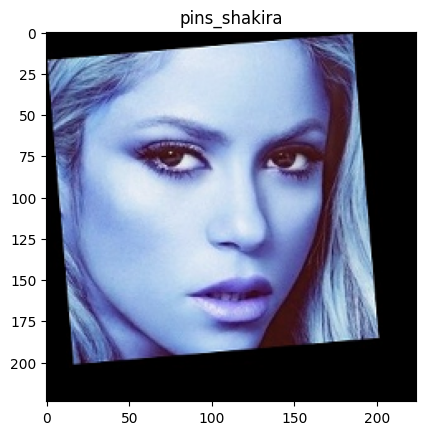

In [11]:
plt.title(classes[10])
plt.imshow(images[10]);

In [12]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata(path)

In [13]:
# VGG_face_weights path
weights_file = '/content/drive/My Drive/Colab Notebooks/My Python Projects/CV Project - 2 - Face Recognition/vgg_face_weights.h5'

In [14]:
# Define VGG_FACE_MODEL architecture

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))	
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))


In [15]:
# Load VGG Face model weights

model.load_weights(weights_file)

In [16]:
from tensorflow.keras.models import Model

vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [17]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

img = load_image(img_path)


# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 9s 9s/step
(2622,)


In [18]:
embeddings = np.zeros((metadata.shape[0], 2622))
k = 0
for i, m in enumerate(metadata):
    try:
        img = load_image(m.image_path())
        if k % 500 == 0:
            print(k)
        # scale RGB values to interval [0,1]
        img = cv2.resize(img, dsize = (224,224))
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
        k += 1
    except Exception as e:
        print(str(e))
        print(i,m)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
6000
1/1 [==============================] - 0s 20ms/step
6500
1/1 [==============================] - 0s 40ms/step
7000
1/1 [==============================] - 0s 24ms/step
7500
1/1 [==============================] - 0s 22ms/step
8000
1/1 [==============================] - 0s 68ms/step
8500
1/1 [==============================] - 0s 34ms/step
9000
1/1 [==============================] - 0s 29ms/step
9500
1/1 [==============================] - 0s 20ms/step
10000
1/1 [==============================] - 0s 21ms/step
10500
1/1 [==============================] - 0s 21ms/step


In [19]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

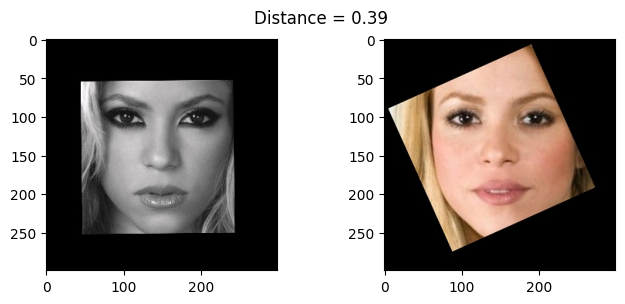

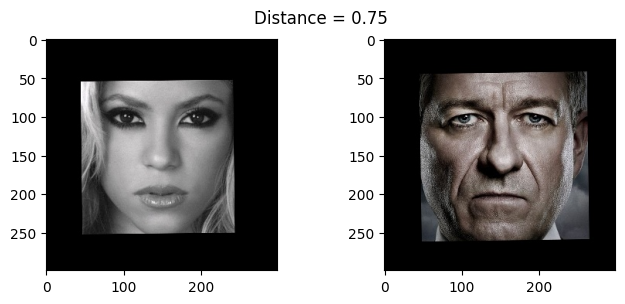

In [20]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

In [21]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0 # 8/9 of the data for training
test_idx = np.arange(metadata.shape[0]) % 9 == 0 # 1/9 of the data for testing

# Train data
X_train = embeddings[train_idx]

# Test data
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

In [22]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Numerical encoding of identities
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [23]:
from sklearn.decomposition import PCA

# PCA for dimension reduction

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [39]:
from sklearn.svm import SVC

clf = SVC(random_state=42, probability = True)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9657477025898078

In [40]:
# Predict
y_pred = clf.predict(X_test)

In [41]:
# Performence metrics
names = [name.split('_')[1].title().strip() for name in df["class"]]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      0.90      0.95        10
      Alexandra Daddario       1.00      1.00      1.00        10
            Alvaro Morte       1.00      1.00      1.00        13
Alycia Debnam Carey Face       1.00      0.92      0.96        13
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      0.88      0.93         8
               Anna Gunn       0.93      1.00      0.97        14
           Anne Hathaway       1.00      0.85      0.92        13
     Barbara Palvin Face       1.00      1.00      1.00         8
      Bellamy Blake Face       1.00      1.00      1.00        14
    Benedict Cumberbatch       1.00      0.92      0.96        13
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       0.82      1.00      

In [42]:
test_image1_path = '/content/drive/My Drive/Colab Notebooks/My Python Projects/CV Project - 2 - Face Recognition/Test_images/Benedict Cumberbatch/Benedict Cumberbatch9.jpg'

test_image2_path = '/content/drive/My Drive/Colab Notebooks/My Python Projects/CV Project - 2 - Face Recognition/Test_images/Dwayne Johnson/Dwayne Johnson4.jpg'

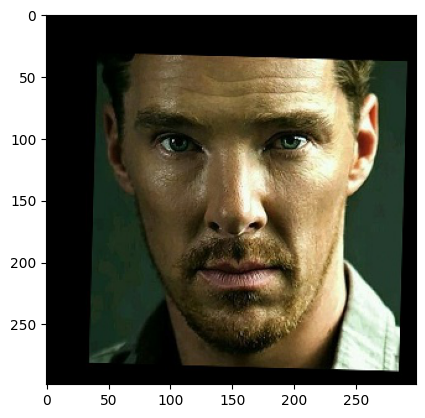

In [43]:
# Load the test images
img1 = plt.imread(test_image1_path)
img2 = plt.imread(test_image2_path)

# Display the test images
plt.imshow(img1);

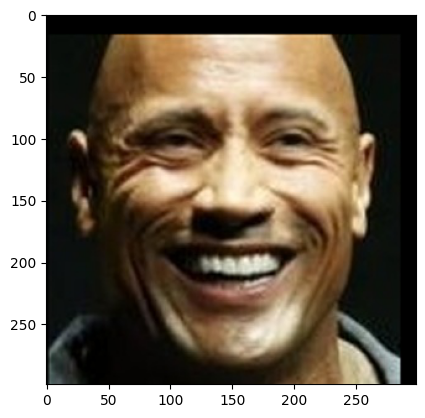

In [44]:
plt.imshow(img2);

In [45]:
def load_metadata1(path):
    metadata1 = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            metadata1.append(IdentityMetadata(path, i, f))
    return np.array(metadata1)

In [46]:
metadata1 = load_metadata1('/content/drive/My Drive/Colab Notebooks/My Python Projects/CV Project - 2 - Face Recognition/Test_images/')

In [47]:
test_idx1 = np.arange(metadata1.shape[0])
X_test1 = embeddings[test_idx1]
X_test1 = pca.transform(X_test1)

In [48]:
example_idx = 0

example_image = load_image(metadata1[test_idx1][example_idx].image_path())
example_prediction = clf.predict([X_test1[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

In [49]:
example_identity

'pins_shakira'

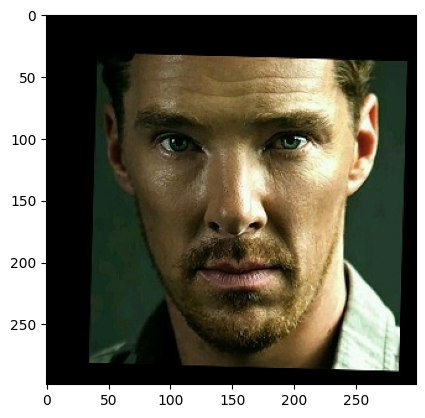

In [50]:
plt.imshow(example_image);

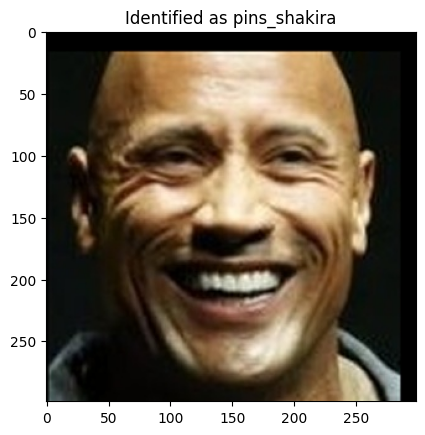

In [51]:
example_idx2 = 1

example_image2 = load_image(metadata1[test_idx1][example_idx2].image_path())
example_prediction2 = clf.predict([X_test1[example_idx2]])
example_identity2 = encoder.inverse_transform(example_prediction2)[0]

plt.imshow(example_image2)
plt.title(f'Identified as {example_identity2}');